[View in Colaboratory](https://colab.research.google.com/github/Abhi001vj/challenges/blob/master/Autoencoders_task.ipynb)

# Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and apply them to faces and similar images search.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [13]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [14]:
!git clone https://github.com/hse-aml/intro-to-dl.git
% cd intro-to-dl

Cloning into 'intro-to-dl'...
remote: Counting objects: 372, done.
remote: Total 372 (delta 0), reused 0 (delta 0), pack-reused 371
Receiving objects: 100% (372/372), 3.35 MiB | 39.84 MiB/s, done.
Resolving deltas: 100% (209/209), done.
/content/intro-to-dl/week4/intro-to-dl


In [15]:
% cd week4

/content/intro-to-dl/week4/intro-to-dl/week4


In [0]:

import sys
sys.path.append("..")
import grading

In [17]:
! pip install tqdm

In [0]:
import numpy as np
import os
import cv2
import pandas as pd
import tarfile
# import tqdm


ATTRS_NAME = "lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
IMAGES_NAME = "lfw-deepfunneled.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
RAW_IMAGES_NAME = "lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [0]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
# from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
# import download_utils
import keras_utils
import numpy as np

In [0]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [21]:
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2018-05-21 07:16:36--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

lfw_attributes.txt  100%[===================>]  14.19M  8.46MB/s    in 1.7s    

2018-05-21 07:16:39 (8.46 MB/s) - ‘lfw_attributes.txt’ saved [14879205/14879205]

--2018-05-21 07:16:40--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  32.9MB/s    in 4.4s    

2018-05-21 0

In [0]:
# we downloaded them for you, just link them here
# download_utils.link_week_4_resources()

In [0]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [23]:
X.shape

(13143, 32, 32, 3)

In [24]:
IMG_SHAPE

(32, 32, 3)

In [0]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


1482

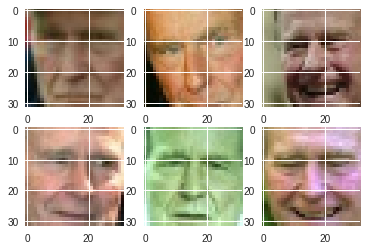

In [26]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

In [0]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


# Going deeper: convolutional autoencoder

PCA is neat but surely we can do better. This time we want you to build a deep convolutional autoencoder by... stacking more layers.

## Encoder

The **encoder** part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (`code_size`).

We recommend to use `activation='elu'` for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`.

Remember to flatten (`L.Flatten()`) output before adding the last dense layer!

## Decoder

For **decoder** we will use so-called "transpose convolution". 

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3 (watch [this video](https://www.coursera.org/learn/intro-to-deep-learning/lecture/auRqf/a-glimpse-of-other-computer-vision-tasks) starting at 5:41).

Here's how "transpose convolution" works:
<img src="images/transpose_conv.jpg" style="width:60%">
In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
```python
L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
```

Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" `L.Flatten()` in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 `L.Conv2DTranspose` layers with the following numbers of output channels: `128, 64, 32, 3`. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last `L.Conv2DTranspose` layer use `activation=None` because that is our final image.

In [28]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    conv = tf.nn.conv2d_transpose(x, f, output_shape=(1, img_size * 2, img_size * 2, 1), strides=[1, 2, 2, 1], padding='SAME')
    with tf.Session() as session:
        result = session.run(conv)
        print("input:")
        print(x[0, :, :, 0])
        print("filter:")
        print(f[:, :, 0, 0])
        print("output:")
        print(result[0, :, :, 0])
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]]
Transpose convolution test for img_size=2, filter_size=3:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]]
Transpose convolution test for img_size=4, filter_size=2:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [13. 13. 14. 14. 15. 15. 16. 16.]
 [13. 13. 14. 14. 15. 15. 16. 16.]]
Transpose convolution test for img_size=4, filter_size=3:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter

In [0]:
! git clone https://github.com/Microsoft/FERPlus.git

In [0]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    input_img = Input(shape=(48, 48, 1))
    encoder.add(Conv2D(32, (3, 3), activation='relu', padding='same')(input_img))
    encoder.add(MaxPooling2D((2, 2), padding='same'))
    encoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))
    encoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))
    encoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))    
    ### YOUR CODE HERE: define encoder as per instructions above ###

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(4*256))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    ### YOUR CODE HERE: define decoder as per instructions above ###
    
    return encoder, decoder

In [30]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    s = reset_tf_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
s = reset_tf_session()

NameError: ignored

In [35]:
# Look at encoder and decoder shapes.
# Total number of trainable parameters of encoder and decoder should be close.
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
__________

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [0]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [0]:
# # we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

# #### uncomment below to continue training from model checkpoint
# #### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [39]:
# autoencoder.fit(x=X_train, y=X_train, epochs=25,
#                 validation_data=[X_test, X_test],
#                 callbacks=[keras_utils.ModelSaveCallback(model_filename),
# #                            keras_utils.TqdmProgressCallback()],
#                 verbose=0,
#                 initial_epoch=last_finished_epoch or 0)
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.ModelSaveCallback(model_filename)],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)

Model saved in autoencoder.000.hdf5
Model saved in autoencoder.001.hdf5
Model saved in autoencoder.002.hdf5
Model saved in autoencoder.003.hdf5
Model saved in autoencoder.004.hdf5
Model saved in autoencoder.005.hdf5
Model saved in autoencoder.006.hdf5
Model saved in autoencoder.007.hdf5
Model saved in autoencoder.008.hdf5
Model saved in autoencoder.009.hdf5
Model saved in autoencoder.010.hdf5
Model saved in autoencoder.011.hdf5
Model saved in autoencoder.012.hdf5
Model saved in autoencoder.013.hdf5
Model saved in autoencoder.014.hdf5
Model saved in autoencoder.015.hdf5
Model saved in autoencoder.016.hdf5
Model saved in autoencoder.017.hdf5
Model saved in autoencoder.018.hdf5
Model saved in autoencoder.019.hdf5
Model saved in autoencoder.020.hdf5
Model saved in autoencoder.021.hdf5
Model saved in autoencoder.022.hdf5
Model saved in autoencoder.023.hdf5
Model saved in autoencoder.024.hdf5


Convolutional autoencoder MSE: 0.005449037164088495


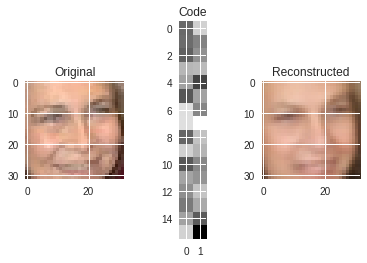

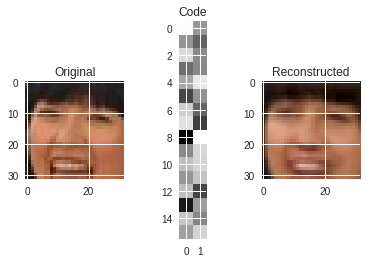

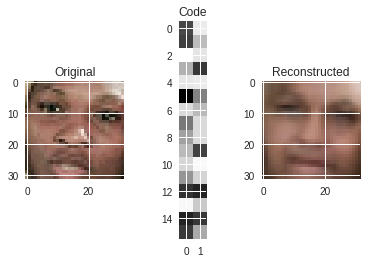

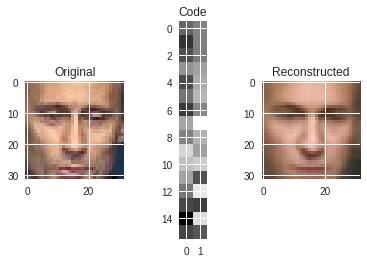

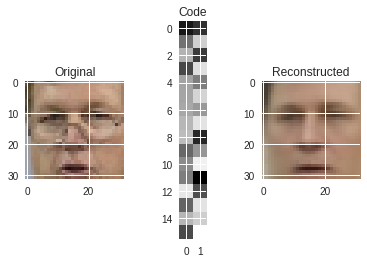

In [41]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [0]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [43]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.005449037186751857
0.005449037164088495


In [0]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

In [0]:
# now take encoder
 
out_dim = 7


inp = L.Input(IMG_SHAPE) #inputs
code = encoder(inp)#pass through encoder
x = L.Dense(128, activation='relu')(code)#adding a dense with some hidden units
x = L.Dense(64, activation='relu')(x)#adding another dense with some hidden units
y = L.Dense(out_dim)(x)#output
cnn_classifier = keras.models.Model(inputs=inp, outputs=y)# create the model
cnn_classifier.compile(optimizer="adamax", loss='categorical_crossentropy')# compile it
# fit it
# cnn_classifier.fit(x=X_train, y=X_train, epochs=25,
#                 validation_data=[X_test, X_test],
#                 callbacks=[keras_utils.ModelSaveCallback(model_filename),
#                            keras_utils.TqdmProgressCallback()]


In [46]:
cnn_classifier.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                421216    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
Total params: 434,151
Trainable params: 434,151
Non-trainable params: 0
_________________________________________________________________


In [50]:
cnn_classifier.fit(x=X_train, Y_train, epochs=25      , validation_data=[X_test, X_test],
                callbacks=[keras_utils.ModelSaveCallback(model_filename)]
                          ]


SyntaxError: ignored